In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR']='/content'
# !kaggle datasets download -d adityajn105/flickr8k

In [ ]:
with open('/content/drive/MyDrive/captions.txt','r') as f:
  next(f)
  cap=f.read()

In [ ]:
mapping = {}
# process lines
for line in cap.split('\n'):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # print('1:',mapping)
    # store the caption
    mapping[image_id].append(caption)

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import PorterStemmer
from nltk.corpus import stopwords
import re
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions=[]
for key in mapping:
  for map in mapping[key]:
    all_captions.append(map)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
token_text=tokenizer.fit_on_texts(all_captions)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 18s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# # extract features from image
# features = {}
# directory = '/content/drive/MyDrive/Flicker8k_Dataset'

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

  0%|          | 0/8099 [00:00<?, ?it/s]

In [ ]:
# pickle.dump(features, open(os.path.join('/content', 'new_image_features.pkl'), 'wb'))

In [ ]:
import os# load features from pickle
import pickle
with open('/content/drive/MyDrive/new_image_features.pkl', 'rb') as f:
    features1 = pickle.load(f)

In [ ]:
len(features1.keys())

8099

In [ ]:
features['2415803492_56a673dc25']

NameError: ignored

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


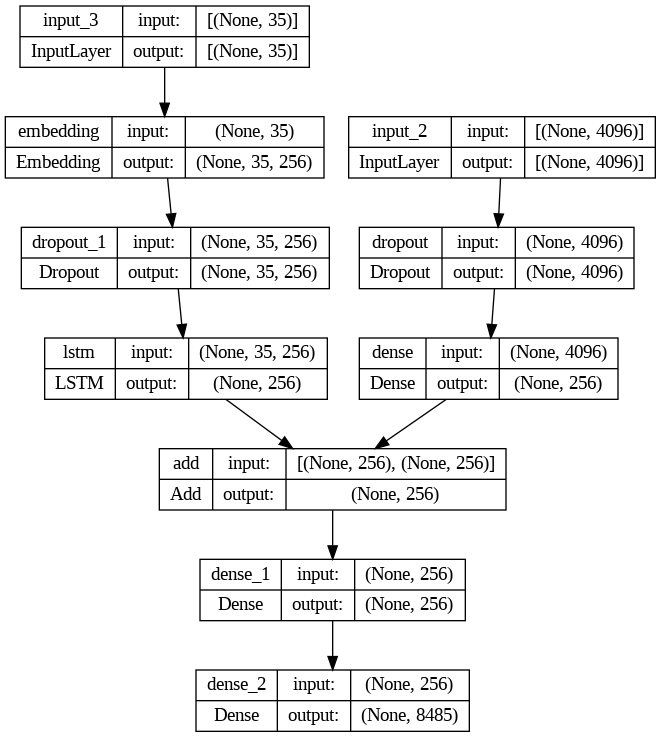

In [ ]:
# Model
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features1, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 67s 296ms/step - loss: 2.1822


In [ ]:
model.save('/content'+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        print('1:',sequence)
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        print('2:',sequence)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        print('3:',yhat)
        # get index with high probability
        yhat = np.argmax(yhat)
        print('4:',yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
y_pred = predict_caption(model, features1[image_id], tokenizer, max_length)
y_pred

1: [1]
2: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
3: [[3.7647169e-10 1.5194833e-09 1.8616710e-04 ... 8.2046930e-10
  2.3261233e-09 2.3220527e-10]]
4: 10
1: [1, 10]
2: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  1 10]]
3: [[1.6798324e-12 6.4489690e-12 2.9210874e-04 ... 4.2894629e-12
  6.5234567e-12 1.9196732e-12]]
4: 20
1: [1, 10, 20]
2: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  1 10 20]]
3: [[1.2031955e-11 1.4396357e-11 1.0876315e-05 ... 1.3211444e-11
  3.7813343e-11 1.5561564e-12]]
4: 24
1: [1, 10, 20, 24]
2: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  1 10 20 24]]
3: [[8.4767138e-13 2.2535001e-12 4.4164996e-04 ... 2.0038420e-12
  2.6727212e-12 1.1744819e-13]]
4: 169
1: [1, 10, 20, 24, 169]
2: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  

'startseq man wearing red helmet is climbing cliff endseq'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/drive/MyDrive/Flicker8k_Dataset/',  image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features1[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq woman in pink shirt is standing on porch endseq


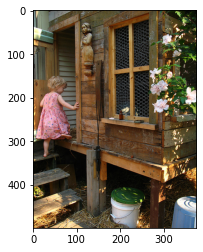

In [ ]:
generate_caption("1000268201_693b08cb0e.jpg")